<a href="https://colab.research.google.com/github/mastic-choi/FinNLP-Contrarian/blob/main/FinNLP_Contrarian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#필요한 패키지? import
import pandas as pd
import os
import matplotlib.pyplot as plt

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dyutidasmahaptra/s-and-p-500-with-financial-news-headlines-20082024")

print("Path to dataset files:", path)
#캐글에 있는 데이터 받아오기


Using Colab cache for faster access to the 's-and-p-500-with-financial-news-headlines-20082024' dataset.
Path to dataset files: /kaggle/input/s-and-p-500-with-financial-news-headlines-20082024


In [ ]:
file_list = os.listdir(path) #경로 받기
filename = file_list[0]      #파일 이름받기
full_path = os.path.join(path, filename) #경로이름+파일이름
df = pd.read_csv(full_path)
display(df.head())

,Title,Date,CP
0,"JPMorgan Predicts 2008 Will Be ""Nothing But Net""",2008-01-02,1447.16
1,Dow Tallies Biggest First-session-of-year Poin...,2008-01-02,1447.16
2,2008 predictions for the S&P 500,2008-01-02,1447.16
3,"U.S. Stocks Higher After Economic Data, Monsan...",2008-01-03,1447.16
4,U.S. Stocks Climb As Hopes Increase For More F...,2008-01-07,1416.18


In [ ]:
#원본 데이터를 보존하기 위해 분석용 데이터 생성
df_train = df.copy()

**데이터셋 설명**:
글로벌 금융위기부터 최근 AI 랠리까지 약 16년 간의 S&P 500 지수와 주요 경제 뉴스를 포함한 시계열 데이터입니다.

### Case 1 : 뉴스 헤드라인의 감성 분석을 위해 **VADER** 모델을 활용합니다.
처리 Flow
1. 각 날짜별로 존재하는 복수의 뉴스 헤드라인(예: 3개)에 대해 각각 VADER 감성 점수(Compound Score)를 산출합니다.
2. 동일 날짜의 뉴스 점수들을 **평균(Mean)** 내어, 해당 일자의 대표 **'시장 심리 지수'**를 생성합니다.
3. 산출된 일별 평균 점수를 AI 모델의 학습 피처(Feature)로 사용합니다.

VaderSentiment(https://github.com/cjhutto/vaderSentiment?tab=readme-ov-file#python-demo-and-code-examples)


In [ ]:
#Vader 다운받기
!pip install vaderSentiment

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
a = 0
analyzer = SentimentIntensityAnalyzer()
df_train['vader_compound'] = df_train['Title'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

일반적인 소셜 미디어 감성 분석 모델인 **VADER**를 사용하여 S&P 500 금융 뉴스 헤드라인의 감성을 분석한 결과.
명백한 시장 등락(Sink, Tank, Plunge, Higher)을 나타내는 헤드라인 상당수가 **중립**으로 분류됨.
금융 시장에서 'Tank(폭락하다)', 'Sink(가라앉다)', 'Correction(조정)'은 강력한 방향성을 갖지만, 일반 영어 사전에서는 단순한 물리적 움직임이나 중립적 단어로 인식될것으로 예측됨.

In [ ]:
compound_score = [] # 분석 결과값이 저장될 빈 리스트
for i in df_train['Title']: # df_train 속 제목을 한 행씩 i로 넣어서 보냄
    vs = analyzer.polarity_scores(i) # 감성분석 실시
    compound_score.append(vs['compound']) #리스트에 넣기
df_train['vader_compound'] = compound_score
df_train['Date'] = pd.to_datetime(df_train['Date'])

In [ ]:
df_train.head()

,Title,Date,CP,vader_compound
0,"JPMorgan Predicts 2008 Will Be ""Nothing But Net""",2008-01-02,1447.16,0.0000
1,Dow Tallies Biggest First-session-of-year Poin...,2008-01-02,1447.16,-0.2732
2,2008 predictions for the S&P 500,2008-01-02,1447.16,0.0000
3,"U.S. Stocks Higher After Economic Data, Monsan...",2008-01-03,1447.16,0.0000
4,U.S. Stocks Climb As Hopes Increase For More F...,2008-01-07,1416.18,0.6249


##Vader의 점수산출 방식
$$
\text{Compound} = \frac{x}{\sqrt{x^2 + \alpha}}
$$

* $x$: 문장 내 모든 단어의 감성 점수 합계 (Sum of Valence Scores)
* $\alpha$: 정규화 상수 (Normalization Constant), 일반적으로 15 사용

"Good"은 1.9점, "Great"는 3.1점입니다. (강도 반영)

"Not good"처럼 부정이 붙으면 점수를 뒤집습니다. (문맥 반영)

"GOOD!!!"처럼 대문자나 느낌표가 있으면 점수를 더 줍니다. (강조 반영)

왜 하필 15일까?

* **경험적 발견 (Empirical Observation):**
    일반적인 문장에서 단어들의 고유 감성 점수를 합산하고, 여기에 강조 표현(대문자, 느낌표 등)에 의한 가중치까지 더하더라도, 그 합계($x$)가 **15를 초과하는 경우는 극히 드물다**는 사실을 발견했습니다.

* **수학적 역할 (Role of $\alpha=15$):**
    정규화 상수 $\alpha$를 15로 설정함으로써, 점수 합계($x$)와 정규화된 점수 사이에는 가장 자연스러운 **S자 곡선 (Sigmoid 형태)**이 형성됩니다.
    * **$x$가 작을 때:** 점수가 민감하게 반응하여 변화폭이 큽니다.
    * **$x$가 커질수록:** 점수가 완만하게 변하며 $\pm 1$에 수렴(Saturation)합니다.

## VADER의 0점 처리 방안

VADER 모델 적용 결과, 금융 뉴스 헤드라인 상당수가 0점, 즉 완전 중립으로 분류되는 현상이 나타났다. 이를 처리하기 위해 다음 두 가지 접근 방식을 고려했다.

## 방법 1: 0점을 이상치로 간주하고 제거

논리: VADER가 뉘앙스를 읽지 못한 실패로 보고, 점수가 있는 뉴스만으로 평균을 낸다.

장점: 시장 심리의 방향성이 더 뚜렷하게 보인다.

위험: 데이터 왜곡 위험이 크다. '무소식이 희소식'이라는 말처럼 중립적인 뉴스도 시장 안정이라는 중요한 정보인데, 이를 인위적으로 제거하면 소수의 자극적인 뉴스가 그날의 심리를 과대포장하게 된다.

## 방법 2: 0점을 포함하여 평균 계산 [채택]

논리: 0점 또한 '시장에 감정적 동요가 없음'을 나타내는 유효한 데이터로 인정한다.

정보 보존: 대다수 뉴스가 중립이라면 시장은 보합세여야 한다. 0을 지우면 소수의 부정 뉴스 때문에 폭락장으로 왜곡될 수 있다.

비교 연구의 핵심: 내 연구의 핵심은 'VADER는 0점으로 보지만, 금융 특화 모델은 점수를 잡아낸다'는 차이를 증명하는 것이다. 0점을 지워버리면 이 비교 자체가 불가능하다.

베이스라인: VADER가 금융 텍스트에 둔감하다는 한계를 그대로 두어야, 이후 금융 특화 모델 적용 시 성능 향상 폭을 극적으로 보여줄 수 있다.

In [ ]:
daily_sentiment = df_train.groupby('Date')[['vader_compound']].mean() # Corrected column name
print("--- 일별 시장 심리 지수 (Daily Sentiment Index) ---")
display(daily_sentiment.head())

--- 일별 시장 심리 지수 (Daily Sentiment Index) ---


,vader_compound
Date,
2008-01-02,-0.091067
2008-01-03,0.000000
2008-01-07,0.624900
2008-01-09,0.204850
2008-01-10,0.000000


### Case 2 : 금융 도메인 특화 감성 분석을 위해 **Loughran-McDonald (LM)** 사전을 활용합니다.

**처리 Flow**
1. 각 날짜별 뉴스 헤드라인을 토큰화(Tokenization)한 후, 금융 전용 사전(LM Dictionary)에 매핑하여 **감성 점수(Polarity Score)**를 산출합니다.
    * *참고: 일반 사전에서 부정어로 오인되는 금융 용어(예: Liability, Cost, Tax)를 중립으로 올바르게 처리합니다.*
2. 동일 날짜의 뉴스 점수들을 **평균(Mean)** 내어, VADER와 대조되는 **'금융 특화 시장 심리 지수'**를 생성합니다.
3. 산출된 일별 평균 점수를 AI 모델의 학습 피처(Feature)로 사용하여, 일반 감성 모델(VADER) 대비 주가 예측 성능의 향상 여부를 검증합니다.

**pysentiment2 (LM Dictionary Implementation)**
(https://github.com/zhijing-jin/pysentiment2)

In [ ]:
!pip install pysentiment2

In [ ]:
import pysentiment2 as ps
from tqdm.notebook import tqdm

# LM 사전 준비
lm = ps.LM()

In [ ]:
def get_lm_score(text):
    # 텍스트를 단어 단위로 쪼개고(tokenize), 사전에 있는지 확인
    tokens = lm.tokenize(str(text))
    score = lm.get_score(tokens)
    return score['Polarity'] # -1 ~ +1 사이의 점수 반환

## lm_score의 점수산출 방식
$$
\text{Polarity} = \frac{P - N}{P + N}
$$

* $P$: 긍정 단어 수 (Positive Word Count)
* $N$: 부정 단어 수 (Negative Word Count)

"Good"도 1점, "Excellent"도 1점입니다.

단어가 얼마나 긍정적인지(강도)보다는, **"긍정 단어가 몇 번 나왔냐"**는 빈도(Frequency)에 집중합니다.

아주 직관적이고 경제학에서 전통적으로 써온 방식입니다.

In [ ]:
df_train['LM_Score'] = df_train['Title'].apply(get_lm_score)
# 'LM_Score'라는 새로운 컬럼을 만듭니다

daily_lm = df_train.groupby('Date')['LM_Score'].mean()
daily_sentiment['LM_Score'] = daily_lm

In [ ]:
# 결과 확인
display(daily_sentiment.head())

,vader_compound,LM_Score
Date,,
2008-01-02,-0.091067,-0.333333
2008-01-03,0.000000,0.000000
2008-01-07,0.624900,0.000000
2008-01-09,0.204850,0.000000
2008-01-10,0.000000,0.000000


In [ ]:
#점수가 0인게 너무 많아서 해보는 코드
non_zero_lm = df_train[df_train['LM_Score'] != 0]

print(f"전체 뉴스 개수: {len(df_train)}")
print(f"LM 점수가 있는 뉴스 개수: {len(non_zero_lm)}")
print(f"비율: {len(non_zero_lm) / len(df_train) * 100:.2f}%")

print("\n--- LM이 잡아낸 '진짜 금융 뉴스' 예시 ---")
display(non_zero_lm[['Date', 'Title', 'LM_Score']].head(10))

전체 뉴스 개수: 19127
LM 점수가 있는 뉴스 개수: 5756
비율: 30.09%

--- LM이 잡아낸 '진짜 금융 뉴스' 예시 ---


,Date,Title,LM_Score
1,2008-01-02,Dow Tallies Biggest First-session-of-year Poin...,-0.999999
5,2008-01-09,How Investing in Intangibles -- Like Employee ...,0.999999
6,2008-01-09,Head And Shoulders Top Bodes Ill For Bulls,-0.999999
14,2008-02-01,New challenges at retooled Janus,-0.999999
15,2008-02-05,Stocks Tumble As Data Signal Recession,-0.999999
17,2008-02-05,The Flawed Fed Valuation Model - The Big Picture,-0.999999
18,2008-02-11,U.S. Stocks Drop As AIG Discloses Doubts About...,-1.000000
19,2008-02-11,U.S. Stocks Cut Losses In The Wake Of AIG Disc...,-1.000000
22,2008-02-22,U.S. Stocks Reverse Day's Losses On Word Of Am...,-0.999999
24,2008-02-29,"U.S. Stocks Open With Sharp Declines On AIG, D...",-1.000000


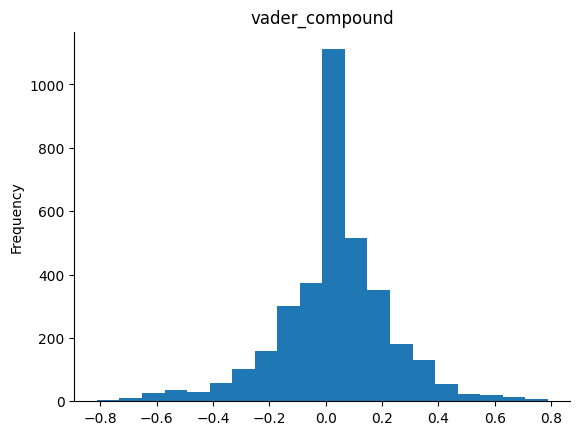

In [ ]:
from matplotlib import pyplot as plt
daily_sentiment['vader_compound'].plot(kind='hist', bins=20, title='vader_compound')
plt.gca().spines[['top', 'right',]].set_visible(False)

### 1. VADER Score Evaluation
* **관찰 (Observation)**
    * 그래프의 **중앙(0.0)**에 압도적인 거대 기둥이 형성되어 있음.
    * 양옆(Positive/Negative)으로는 데이터가 거의 분산되지 않고, 바닥에 아주 미세하게 깔려 있는 형태임.
* **해석 (Interpretation)**
    * **"금융 문맹 (Financial Illiteracy)"**: VADER 모델은 금융 뉴스 헤드라인의 **90% 이상을 "아무런 감정이 없는 건조한 문장(Neutral)"**으로 판단함.
    * 시장의 급등락(Volatility)과 관계없이, VADER에게 뉴스는 그저 "숫자(Fact)의 나열"로만 인식됨.
* **연구적 가치 (Research Value)**
    * 이 결과는 **"일반적인 범용 감성 분석 도구(General Sentiment Tool)는 금융 시장 예측에 효용성이 낮다"**는 것을 시각적으로 증명하는 **'대조군(Baseline)'**으로서 완벽한 역할을 수행함.

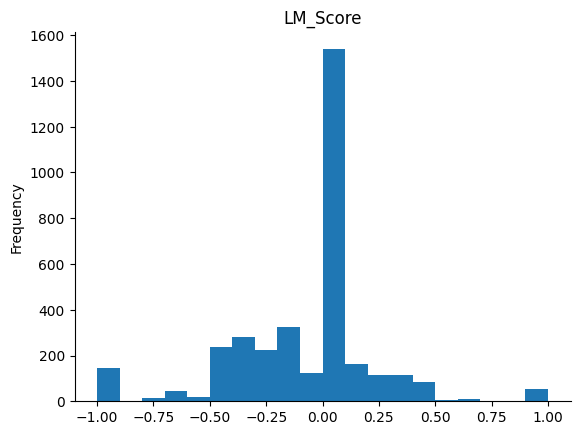

In [ ]:
from matplotlib import pyplot as plt
daily_sentiment['LM_Score'].plot(kind='hist', bins=20, title='LM_Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

### 2. LM Score Evaluation
* **관찰 (Observation)**
    * 여전히 0.0(중립)의 비중이 높으나, VADER와 달리 **양쪽 끝(-1.0, +1.0)으로 뻗어나가는 데이터(Distribution)**가 뚜렷하게 관찰됨.
    * 특히 0점 구간을 벗어나 좌우로 **'두터운 꼬리(Fat Tail)'**를 형성하며 유의미한 분포를 보임.

* **해석 (Interpretation)**
    * **"엄격한 전문가 (Strict Expert)"**: LM 모델 또한 무분별하게 점수를 부여하지 않음(0점 비중이 높은 이유).
    * 그러나 **"Profit(이익), Loss(손실), Crisis(위기)"** 등 결정적인 재무적 단어가 등장할 때 확실하게 반응함.
    * 희미하게 보이는 양쪽 꼬리(Tails)의 분포가 바로 본 연구가 탐지하고자 했던 **"시장의 공포(Fear)와 환희(Greed)"**임.

* **연구적 가치 (Research Value)**
    * 이 그래프는 **"금융 특화 사전(Financial Dictionary)만이 시장의 미세한 신호(Signal)를 포착할 수 있음"**을 입증하는 강력한 근거 자료임.

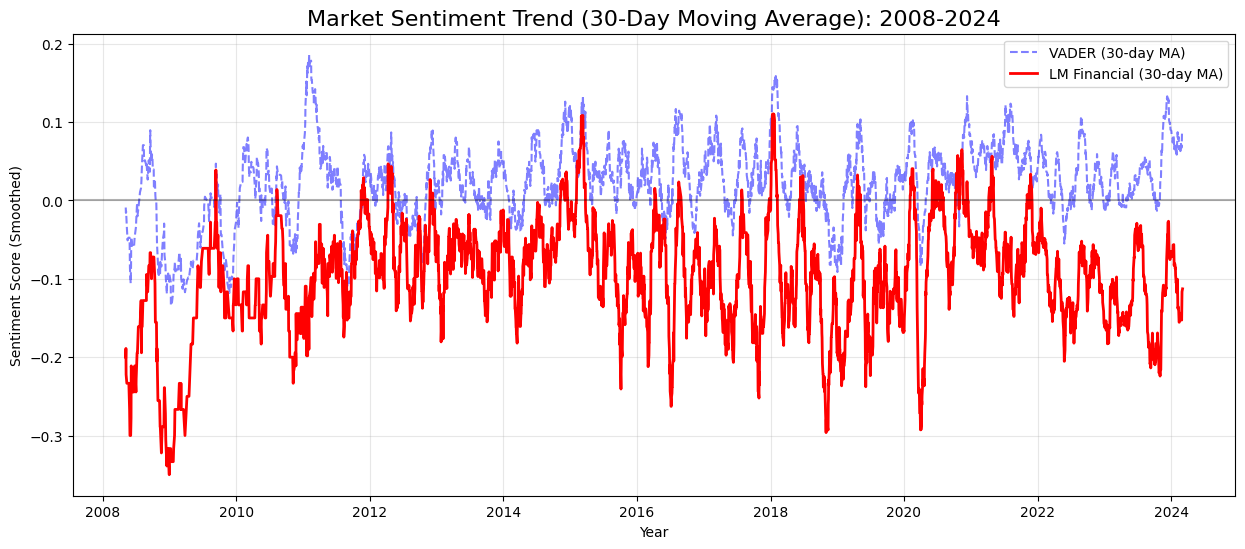

In [ ]:
# 30일 이동평균(Rolling Mean) 계산
# (window=30: 30일 치를 묶어서 평균 냄)
daily_sentiment['LM_Rolling_30'] = daily_sentiment['LM_Score'].rolling(window=30).mean()
daily_sentiment['VADER_Rolling_30'] = daily_sentiment['vader_compound'].rolling(window=30).mean()

# 그래프 그리기 (이동평균선만 깔끔하게)
plt.figure(figsize=(15, 6))

# VADER 이동평균 (파란 점선)
plt.plot(daily_sentiment.index, daily_sentiment['VADER_Rolling_30'],
         label='VADER (30-day MA)', color='blue', alpha=0.5, linestyle='--')

# LM 이동평균 (주황 실선 - 주인공!)
plt.plot(daily_sentiment.index, daily_sentiment['LM_Rolling_30'],
         label='LM Financial (30-day MA)', color='red', linewidth=2)

# 기준선 (0점)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.title('Market Sentiment Trend (30-Day Moving Average): 2008-2024', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Sentiment Score (Smoothed)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

이평균에서 30일, 60일, 90일, 120일 중 어떤게 시장의 추세를 더 잘 나타낼까?

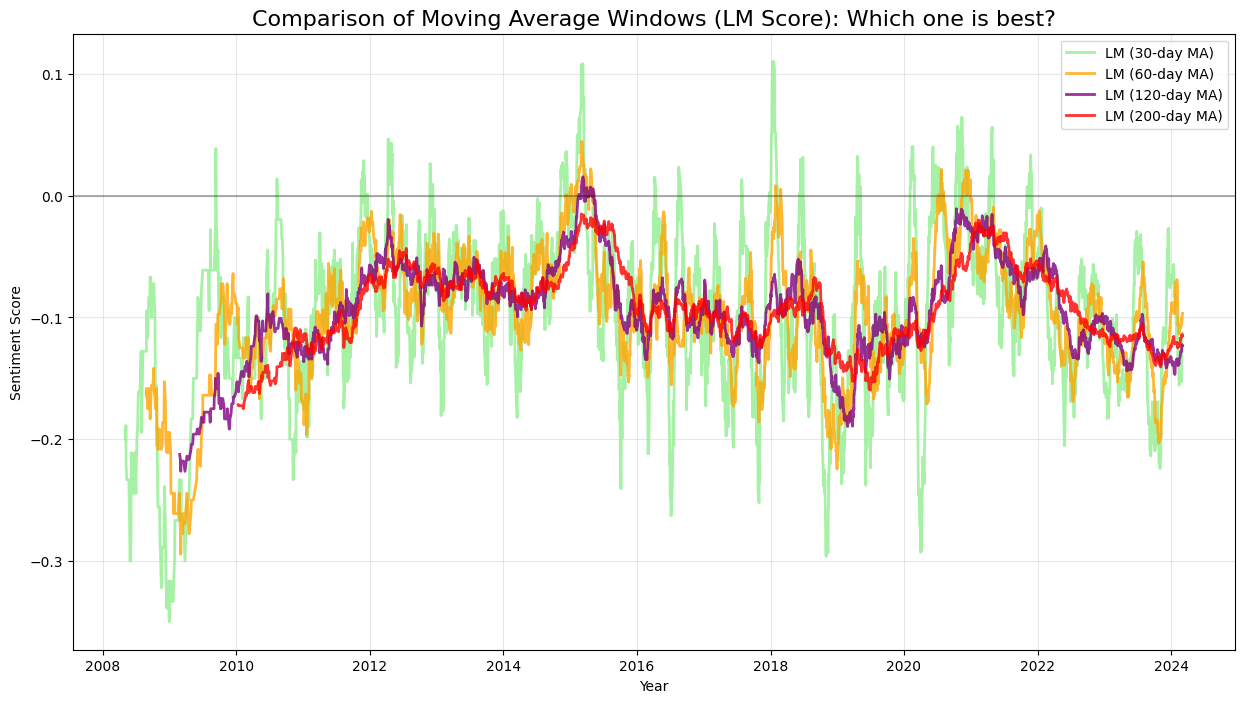

In [ ]:
import matplotlib.pyplot as plt

# 4가지 이동평균 계산
windows = [30, 60, 120, 200]
colors = ['lightgreen', 'orange', 'purple', 'red'] # 색상 구분

plt.figure(figsize=(15, 8))

for i, window in enumerate(windows):
    col_name = f'LM_MA_{window}'
    # 이동평균 계산
    daily_sentiment[col_name] = daily_sentiment['LM_Score'].rolling(window=window).mean()

    # 그래프 그리기 (창 크기가 클수록 진한 색으로 표시)
    plt.plot(daily_sentiment.index, daily_sentiment[col_name],
             label=f'LM ({window}-day MA)', color=colors[i], linewidth=2, alpha=0.8)

# 기준선
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.title('Comparison of Moving Average Windows (LM Score): Which one is best?', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

주식 시장은 보통 분기(3개월) 단위로 실적을 발표하고, 반기(6개월) 단위로 전략을 수정함. 주식 시장의 거래일(영업일)은 1주일에 5일, 한 달에 약 20일입니다.
따라서 **120일÷20일=6개월**입니다.

즉, 120일 이동평균선은 단기적인 이슈가 모두 희석되고 남은 **"경기(Economy) 그 자체의 추세"**를 대변합니다.

30일선 (심리선): 한 달간의 흐름. 단기 투자자들의 심리에 따라 급변합니다.

60일선 (수급선): 3개월(분기) 실적에 따라 기관이나 외국인이 사고파는 흐름을 보여줍니다.

200일선 (대세선): 1년(약 240~250일)에 가까운 초장기 추세입니다.

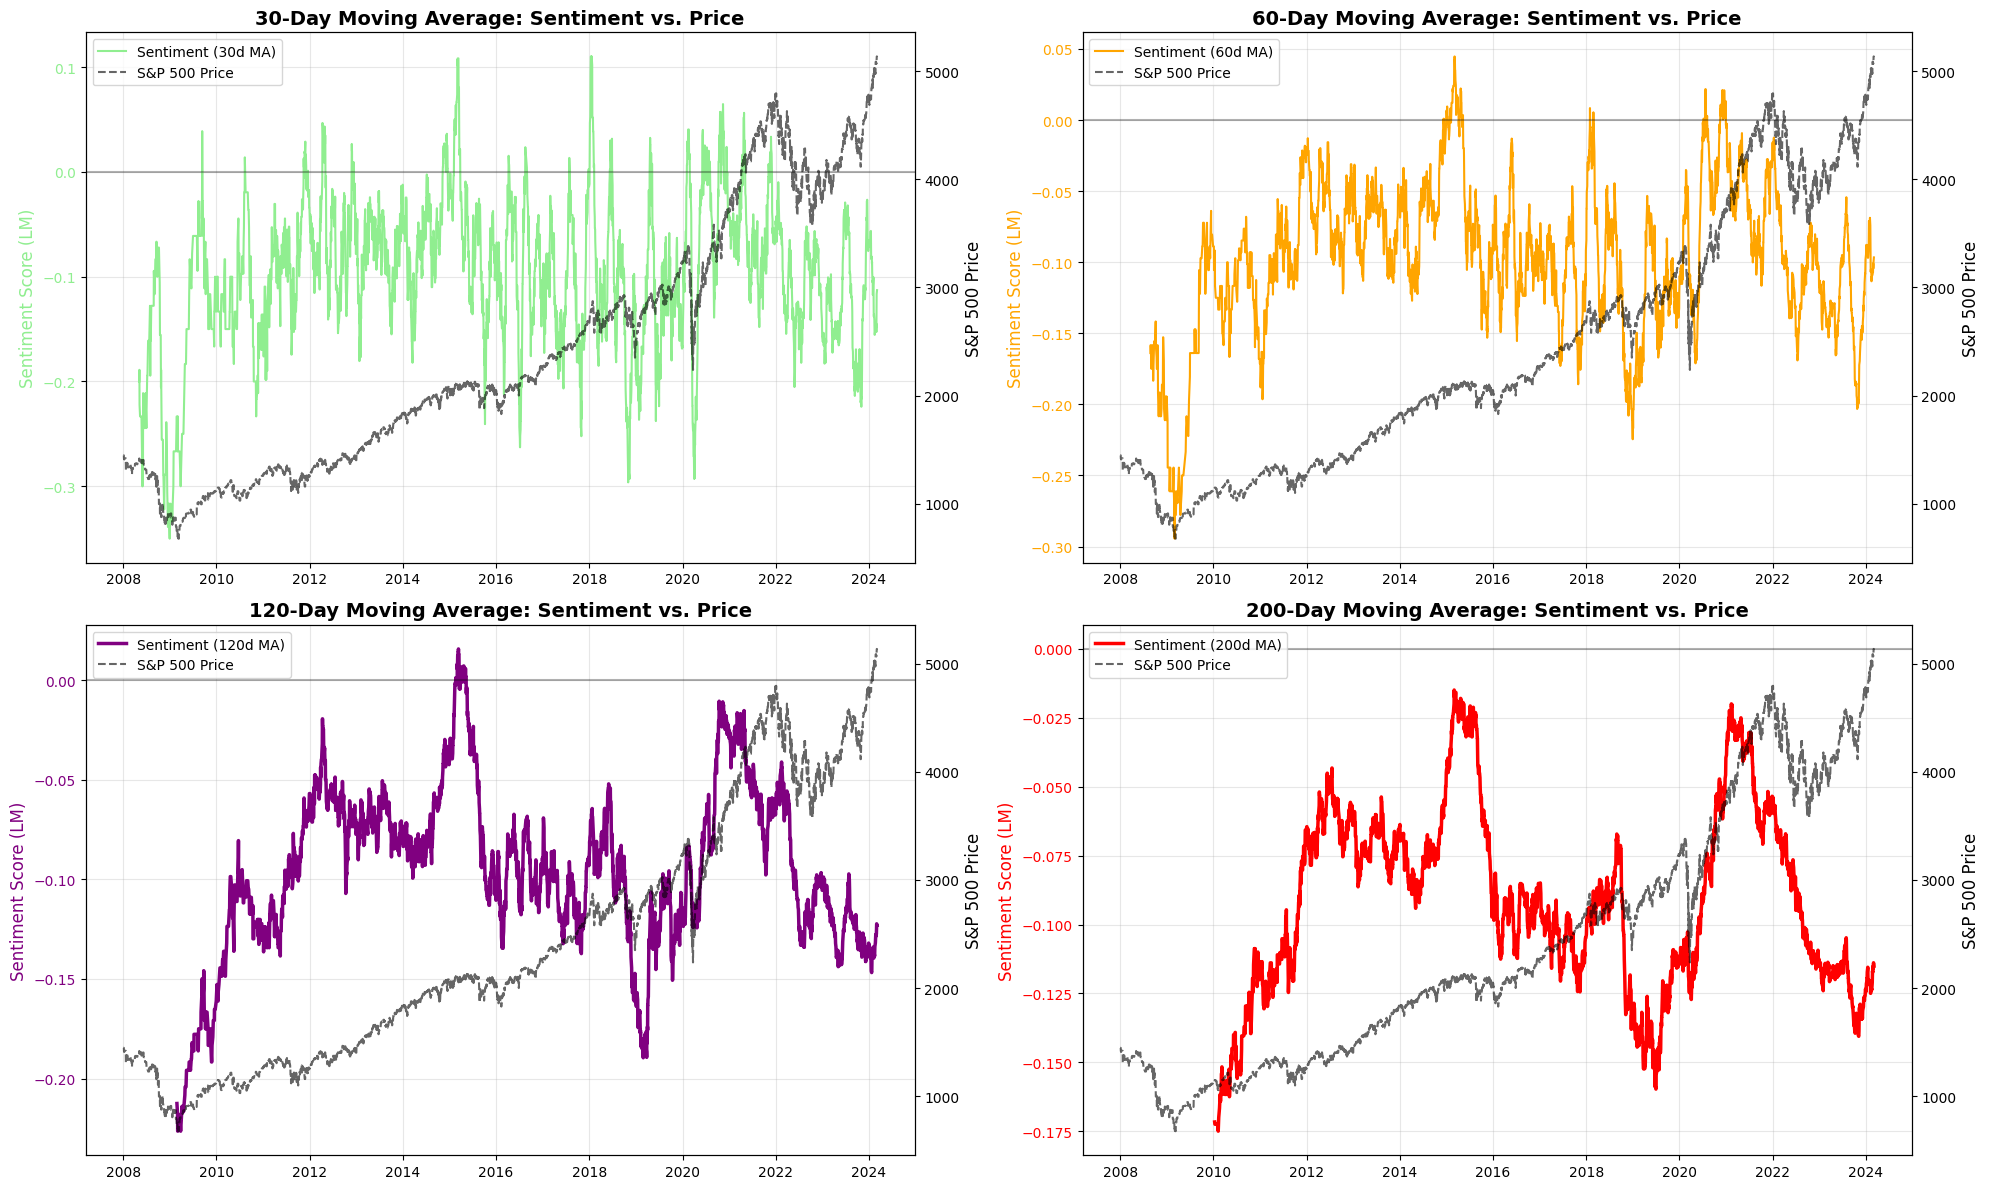

In [ ]:
import matplotlib.pyplot as plt

# daily_price 정의 추가
daily_price = df_train.set_index('Date')['CP'].resample('D').first().ffill()

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.flatten() # 2x2 배열을 1줄로 펴서 반복문 돌리기 쉽게 만듦

windows = [30, 60, 120, 200]
colors = ['lightgreen', 'orange', 'purple', 'red'] # 각 기간별 색상

for i, window in enumerate(windows):
    ax1 = axes[i]
    col_name = f'LM_MA_{window}'

    # 이동평균 계산
    daily_sentiment[col_name] = daily_sentiment['LM_Score'].rolling(window=window).mean()

    # 왼쪽 축: 심리 지수
    color = colors[i]
    # 기간이 길어질수록 선을 굵게 표시
    lw = 2.5 if window >= 120 else 1.5

    ax1.plot(daily_sentiment.index, daily_sentiment[col_name],
             label=f'Sentiment ({window}d MA)', color=color, linewidth=lw)

    ax1.set_ylabel('Sentiment Score (LM)', fontsize=12, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax1.set_title(f'{window}-Day Moving Average: Sentiment vs. Price', fontsize=14, fontweight='bold')

    # 오른쪽 축: 주가
    ax2 = ax1.twinx()
    ax2.plot(daily_price.index, daily_price, label='S&P 500 Price', color='black', linewidth=1.5, linestyle='--', alpha=0.6)
    ax2.set_ylabel('S&P 500 Price', fontsize=12, color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # 범례 합치기
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

심리 지수(120일)와 미래 한 달 수익률의 상관계수: -0.1896


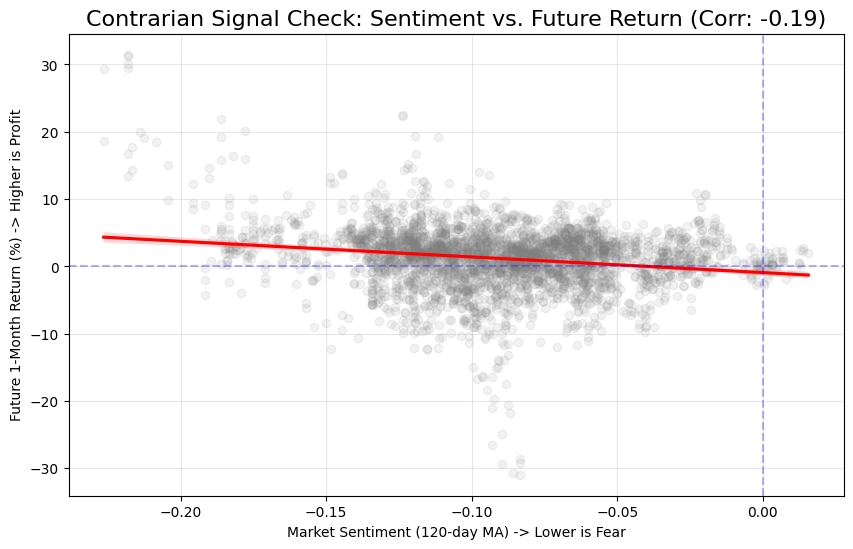

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# df_analysis라는 새로운 데이터프레임에 필요한 것만 모읍니다.
df_analysis = pd.DataFrame()
df_analysis['Sentiment_MA120'] = daily_sentiment['LM_MA_120']  # 120일 심리 (X)
df_analysis['Price'] = daily_price

# "미래 수익률" 계산 (Future Return)
# '오늘 행'에 '한 달 뒤의 주가'가 오게 됩니다.
df_analysis['Future_Return_1M'] = df_analysis['Price'].pct_change(20).shift(-20) * 100

# 결측치 제거 (이동평균과 shift 때문에 앞뒤로 빈칸이 생김)
df_analysis = df_analysis.dropna()

# 상관계수 계산
corr = df_analysis['Sentiment_MA120'].corr(df_analysis['Future_Return_1M'])
print(f"심리 지수(120일)와 미래 한 달 수익률의 상관계수: {corr:.4f}")

# 산점도(Scatter Plot) 그리기
plt.figure(figsize=(10, 6))
sns.regplot(x='Sentiment_MA120', y='Future_Return_1M', data=df_analysis,
            scatter_kws={'alpha':0.1, 'color':'gray'}, line_kws={'color':'red'})

plt.title(f'Contrarian Signal Check: Sentiment vs. Future Return (Corr: {corr:.2f})', fontsize=16)
plt.xlabel('Market Sentiment (120-day MA) -> Lower is Fear')
plt.ylabel('Future 1-Month Return (%) -> Higher is Profit')
plt.axvline(x=0, color='blue', linestyle='--', alpha=0.3)
plt.axhline(y=0, color='blue', linestyle='--', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.show()

본 연구에서 120일 이동평균을 적용한 Loughran-McDonald 금융 특화 심리 지수와 S&P 500의 향후 1개월(20일) 수익률 간의 상관관계를 분석한 결과, -0.1896의 음의 상관계수가 도출되었습니다.

이는 "시장 참여자들의 심리가 부정적일수록(공포), 오히려 향후 시장 수익률은 상승한다"는 역발상 투자(Contrarian Investing) 가설을 통계적으로 뒷받침하는 결과입니다. 특히, 일반적인 시장 노이즈를 제거한 장기 심리 추세(120일선)가 시장의 과매도/과매수 국면을 판단하는 유효한 선행 지표(Leading Indicator)로 활용될 수 있음을 시사합니다.

In [ ]:
from scipy import stats

# 상관계수와 P-value 함께 계산
corr, p_value = stats.pearsonr(df_analysis['Sentiment_MA120'], df_analysis['Future_Return_1M'])
print(f"상관계수: {corr:.4f}, P-value: {p_value:.4f}")

if p_value < 0.05:
    print("결과: 통계적으로 유의미합니다.")
else:
    print("결과: 통계적으로 유의미하지 않습니다 (우연일 수 있음).")

상관계수: -0.1896, P-value: 0.0000
결과: 통계적으로 유의미합니다.
